# Project 2 - Feature Selection

## Part 1
3 classifiers: LDA, CNN and kNN. 

2 feature selection methods: backward selection, lasso embedding.

In [116]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


### Importing the dataset

Here we have a dataset of cats (label 0) and dogs (label 1), images of size 64x64

In [117]:
df = pd.read_csv('catdogdata.txt', delimiter=' ')


df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [118]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

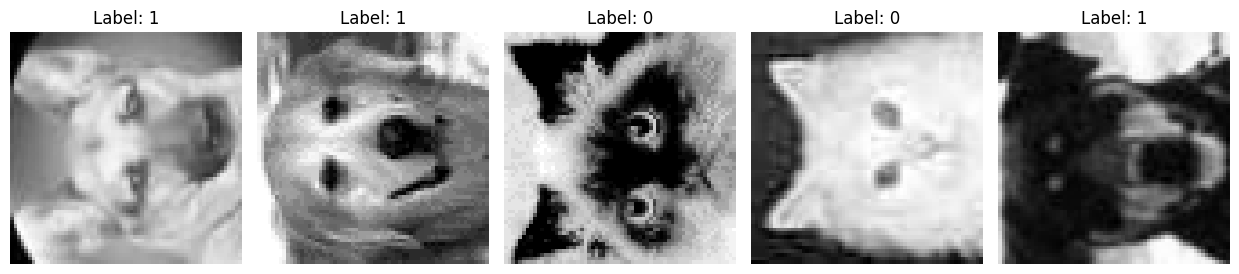

In [119]:
# plot example images
plot_examples(df, n=5)

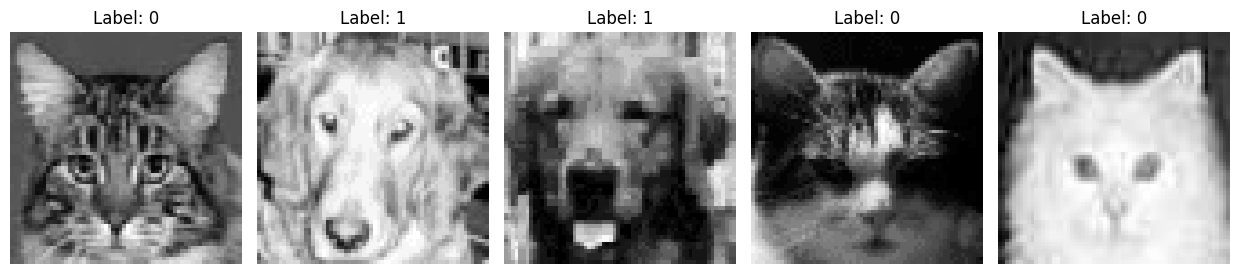

In [120]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

### Fixing the models

#### CNN

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# import pytorch lightning
import pytorch_lightning as pl

In [122]:
class PixelLassoCNN(pl.LightningModule):
    def __init__(self, l1_lambda=1e-2):
        super().__init__()
        self.input_mask = nn.Parameter(torch.ones(1, 1, 64, 64))  # same size as input

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)

        self.l1_lambda = l1_lambda

    def forward(self, x):
        x = x * self.input_mask  # Apply the learnable mask
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss

        self.log("train_loss", total_loss)
        return total_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("test_loss", total_loss)
        self.log("test_accuracy", total_accuracy)
        return total_loss, total_accuracy
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        ce_loss = F.cross_entropy(logits, y)

        # L1 penalty on the input mask
        l1_loss = self.l1_lambda * self.input_mask.abs().sum()
        total_loss = ce_loss + l1_loss
        
        total_accuracy = (logits.argmax(dim=1) == y).float().mean()

        self.log("val_loss", total_loss)
        self.log("val_accuracy", total_accuracy)
        return total_loss, total_accuracy
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [123]:
# Load the data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Split the data into features and labels

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X = X.reshape(-1, 1, 64, 64)  # Reshape for CNN input

# Split the data into training and validation sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 126
Validation set size: 32
Test set size: 40


In [166]:
# Initialize the model
model = PixelLassoCNN()

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
)

In [167]:
# train the model
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [168]:
# evaluate model
model.eval()

# retrieve the test accuracy
trainer.test(model, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7250000238418579     │
│         test_loss         │     0.67429518699646      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.67429518699646, 'test_accuracy': 0.7250000238418579}]

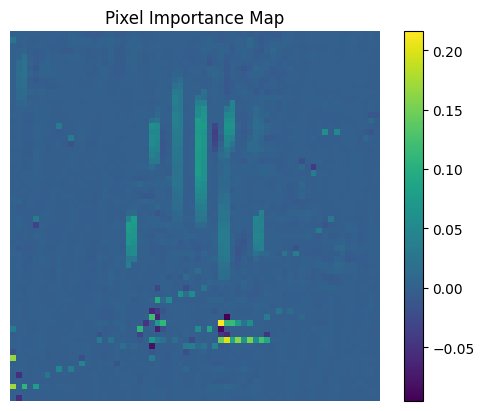

In [169]:
import matplotlib.pyplot as plt

# Detach and move to CPU
mask = model.input_mask.detach().cpu().squeeze()

# Plot
plt.imshow(mask, cmap='viridis')
plt.title("Pixel Importance Map")
plt.colorbar()
plt.axis('off')
plt.show()


### CV for finding optimal Lambda

In [128]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


In [129]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(model.device), y.to(model.device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


In [130]:
def run_cv_for_lambdas(dataset, lambdas, k_folds=5, batch_size=64, max_epochs=10):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    results = []

    for lmbda in lambdas:
        print(f"\nTesting lambda = {lmbda}")
        val_scores = []
        sparsities = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            print(f"  Fold {fold+1}/{k_folds}")
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size)

            model = PixelLassoCNN(l1_lambda=lmbda)

            trainer = pl.Trainer(
                max_epochs=max_epochs,
                enable_progress_bar=False,
                logger=False,
                accelerator="auto",
                enable_model_summary=False,
            )
            
            trainer.fit(model, train_loader, val_loader)

            # Eval on validation set
            acc = evaluate_model(model, val_loader)
            mask = model.input_mask.detach().cpu().squeeze()
            mask = mask.numpy()
            sparsity = (mask < 0.01).sum() / mask.size
            print(f"  Validation Accuracy: {acc:.4f}")
            print(f"  Sparsity: {sparsity:.4f}")
            val_scores.append(acc)
            sparsities.append(sparsity)

        results.append({
            "lambda": lmbda,
            "val_acc_mean": np.mean(val_scores),
            "val_acc_std": np.std(val_scores),
            "sparsity_mean": np.mean(sparsities),
            "mask": model.input_mask,
        })

    return results

def plot_cv_results(results):
    lambdas = [r["lambda"] for r in results]
    accs = [r["val_acc_mean"] for r in results]
    sparsities = [r["sparsity_mean"] for r in results]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(lambdas, accs, marker='o')
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(lambdas, sparsities, marker='o', color="red")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Sparsity (fraction of near-zero pixels)")

    plt.tight_layout()
    plt.show()

In [174]:
import torch
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Silence Lightning logs
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

lambda_grid = np.logspace(-2, 0, 5)
num_repeats = 5
pixel_selection_counts = []

start_time = time.time()

# Run multiple repeats
for repeat in range(num_repeats):
    print(f"Running cross-validation repeat {repeat+1}/{num_repeats}...")
    
    # Run cross-validation
    results = run_cv_for_lambdas(train_dataset, lambdas=lambda_grid, max_epochs=150)
    
    # Assume run_cv_for_lambdas returns the best trained model
    best_model = max(results, key=lambda x: x["val_acc_mean"])
    best_lambda = best_model["lambda"]
    
    # retrain on the full training set with the best lambda
    print(f"Retraining with best lambda: {best_lambda}")
    model = PixelLassoCNN(l1_lambda=best_lambda)
    trainer = pl.Trainer(
        max_epochs=150,
        enable_progress_bar=False,
        logger=False,
        accelerator="auto",
        enable_model_summary=False,
    )
    trainer.fit(model, train_loader, val_loader)
    # Evaluate on the test set
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    # Get the mask
    best_mask = model.input_mask.detach().cpu().squeeze().numpy()
    
    # Threshold the mask (select "active" pixels)
    threshold = 0.01
    selected_pixels = (best_mask > threshold).astype(np.float32)
    
    pixel_selection_counts.append(selected_pixels)

end_time = time.time()
print(f"Cross-validation took {end_time - start_time:.2f} seconds")

# Stack and sum selection maps
pixel_selection_counts = np.stack(pixel_selection_counts, axis=0)  # (num_repeats, H, W)
consensus_map = pixel_selection_counts.sum(axis=0)  # (H, W)

# Normalize to [0, 1] if you want
consensus_map_normalized = consensus_map / num_repeats



Running cross-validation repeat 1/5...

Testing lambda = 0.01
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/oskar/Coding/MVE441/project_2/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


  Validation Accuracy: 0.7308
  Sparsity: 0.0000
  Fold 2/5
  Validation Accuracy: 0.8000
  Sparsity: 0.0000
  Fold 3/5
  Validation Accuracy: 0.8400
  Sparsity: 0.0000
  Fold 4/5
  Validation Accuracy: 0.6400
  Sparsity: 0.0000
  Fold 5/5
  Validation Accuracy: 0.6400
  Sparsity: 0.0000

Testing lambda = 0.03162277660168379
  Fold 1/5
  Validation Accuracy: 0.8077
  Sparsity: 0.0000
  Fold 2/5
  Validation Accuracy: 0.7200
  Sparsity: 0.0000
  Fold 3/5
  Validation Accuracy: 0.8800
  Sparsity: 0.0000
  Fold 4/5
  Validation Accuracy: 0.7600
  Sparsity: 0.0000
  Fold 5/5
  Validation Accuracy: 0.4400
  Sparsity: 0.0000

Testing lambda = 0.1
  Fold 1/5
  Validation Accuracy: 0.5385
  Sparsity: 0.0000
  Fold 2/5
  Validation Accuracy: 0.7600
  Sparsity: 0.0000
  Fold 3/5
  Validation Accuracy: 0.7200
  Sparsity: 0.0000
  Fold 4/5
  Validation Accuracy: 0.5200
  Sparsity: 0.0000
  Fold 5/5
  Validation Accuracy: 0.7200
  Sparsity: 0.0000

Testing lambda = 0.31622776601683794
  Fold 1/5
  

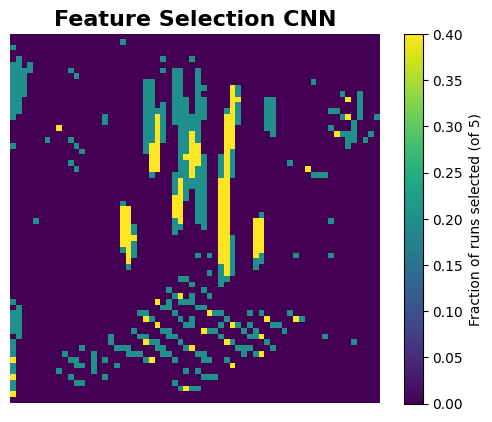

In [189]:
# Plot feature selection map
plt.imshow(consensus_map_normalized, cmap="viridis", interpolation="nearest")
plt.title("Feature Selection CNN", fontsize=16, fontweight="bold")
plt.colorbar(label="Fraction of runs selected (of 5)")
plt.axis("off")
plt.show()

### SVM using Lasso and Forward selection

In [178]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.svm import SVC
import numpy as np
import pandas as pd

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


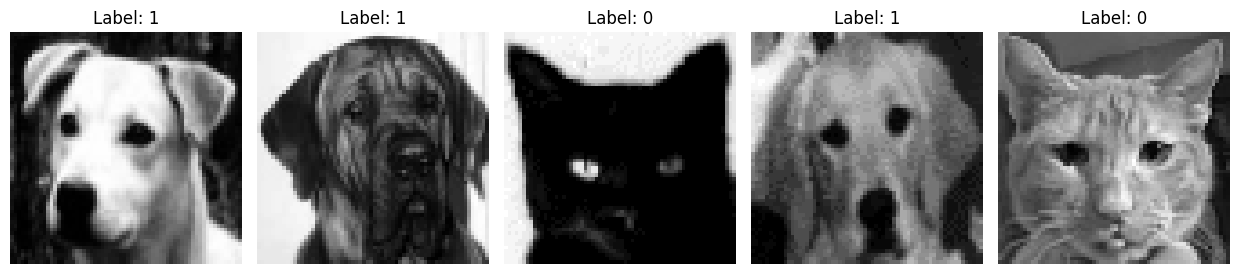

In [179]:
df = pd.read_csv('catdogdata.txt', delimiter=' ')
df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries

rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

print(y)
plot_examples(df, n=5)

In [180]:
# Pipeline for SVM using F-test
pipelineSVMFilter = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),  # Select top 30 features
    ('svm', SVC(kernel='linear'))
])

# Pipeline for SVM using embedded Lasso
pipelineSVMLasso = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000), 
        prefit=False
    )),
    ('svm', SVC(kernel='linear'))
])

pipelineSVMBoth = Pipeline([
    ('scaler', StandardScaler()),
    ('filtering', SelectKBest(score_func=f_classif, k=100)),  # First, F-test to top 50 features
    ('feature_selection', SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        prefit=False
    )),  # Then, Lasso
    ('svm', SVC(kernel='linear'))
])


In [181]:
# Cross-validate and return the fitted estimators
def fit_and_evaluate_pipeline(pipeline, Xdata, ydata, cv = 5):
    cv_results = cross_validate(
        pipeline, Xdata, ydata, 
        cv=5, 
        return_estimator=True
    )

    # Access all trained estimators
    fitted_pipelines = cv_results['estimator']

    # Now: Extract feature selection masks from each estimator
    masks = []
    for pipe in fitted_pipelines:
        mask = pipe.named_steps['feature_selection'].get_support()
        masks.append(mask)

    # Stack masks into array
    masks = np.array(masks)

    # How often each feature was selected across CV folds
    selection_counts = np.sum(masks, axis=0)

    print("Selection frequency for each feature:", selection_counts)

    print("CV Accuracy:", np.mean(cv_results['test_score']))

    return selection_counts, cv_results


Selection frequency for each feature: [0 0 0 ... 0 0 0]
CV Accuracy: 0.6757692307692307


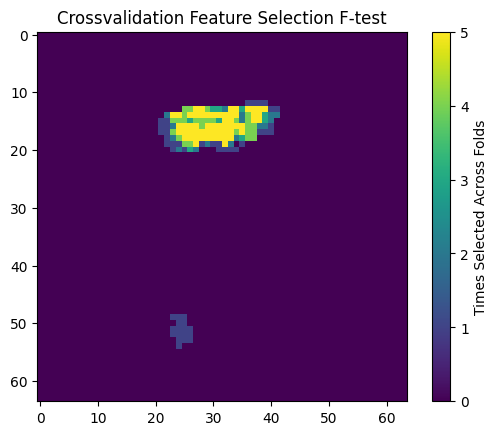

In [182]:
# Fit SVM and feature select using F-test

countsSVM, cvSMV = fit_and_evaluate_pipeline(pipelineSVMFilter, X, y)

size = (64,64)

heatmap = countsSVM.reshape(*size)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar(label='Times Selected Across Folds')
plt.title('Crossvalidation Feature Selection F-test')
plt.show()

Selection frequency for each feature: [0 0 0 ... 0 0 0]
CV Accuracy: 0.7723076923076924


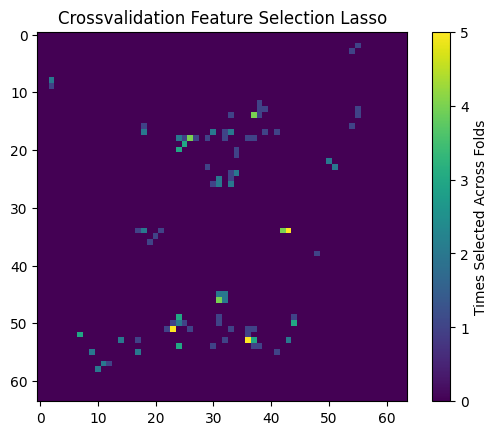

In [183]:
# Fit SVM and feature select using Lasso + LR

countsSVMLasso, cvSMVLasso = fit_and_evaluate_pipeline(pipelineSVMLasso, X, y)

size = (64,64)

heatmap = countsSVMLasso.reshape(*size)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar(label='Times Selected Across Folds')
plt.title('Crossvalidation Feature Selection Lasso')
plt.show()

Selection frequency for each feature: [0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 0 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 0 1 2 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 2]
CV Accuracy: 0.7015384615384616


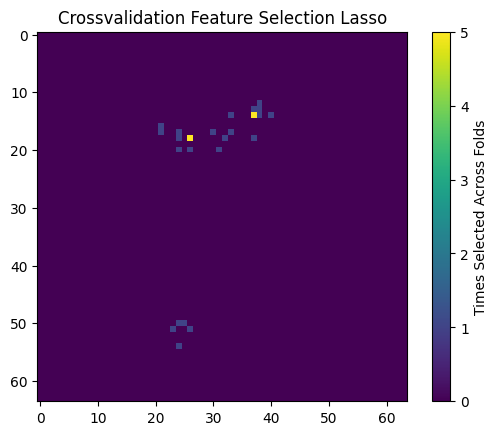

In [184]:
# Fit SVM and feature select using F-test and Lasso

countsSVMBoth, cvSVMBoth = fit_and_evaluate_pipeline(pipelineSVMBoth, X, y)

fit_pipe = cvSVMBoth['estimator']

size = (64,64)
full_masks = []
for pipe in fit_pipe:
    # Step 1: Which features survived the initial filter
    filtering_support = pipe.named_steps['filtering'].get_support()
    filtered_indices = np.where(filtering_support)[0]

    # Step 2: Which features survived Lasso among the filtered
    lasso_support = pipe.named_steps['feature_selection'].get_support()

    # Step 3: Map back to original feature space
    full_mask = np.zeros(X.shape[1], dtype=bool)
    full_mask[filtered_indices[lasso_support]] = True

    full_masks.append(full_mask)

# Stack masks
full_masks = np.array(full_masks)

# How often each pixel was selected
selection_counts = np.sum(full_masks, axis=0)

heatmap = selection_counts.reshape(*size)

plt.imshow(heatmap, cmap='viridis')
plt.colorbar(label='Times Selected Across Folds')
plt.title('Crossvalidation Feature Selection Lasso')
plt.show()

# Embedded Lasso Logistic Regression & F-Test using Logistic Regression

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

# F-Test and T-Test

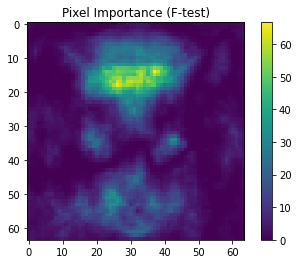

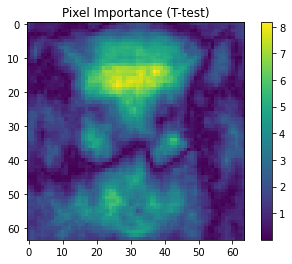

In [260]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


f_statistic, p_values = f_classif(X, y)
sorted_by_feature_index = np.argsort(f_statistic)[::-1] #descending order..

f_statistic_reshaped = np.reshape(f_statistic,(64,64))

plt.imshow(f_statistic_reshaped, cmap='viridis',interpolation="nearest")
plt.title("Pixel Importance (F-test)")
plt.colorbar()
plt.show()

X0 = X[y == 0]
X1 = X[y == 1]

t_statistics, p_values = ttest_ind(X0, X1)

sorted_by_feature_index_ttest = np.argsort(np.abs(t_statistics))[::-1]
t_statistics_reshaped = np.reshape(t_statistics, (64, 64))

plt.figure()
plt.imshow(np.abs(t_statistics_reshaped), cmap='viridis',interpolation="nearest")
plt.title("Pixel Importance (T-test)")
plt.colorbar()
plt.show()

# F-test w. Logistic Regression
Using CV, determine how many features (pixels) you need for classification
Repeat the above a few times - is the selection stable?

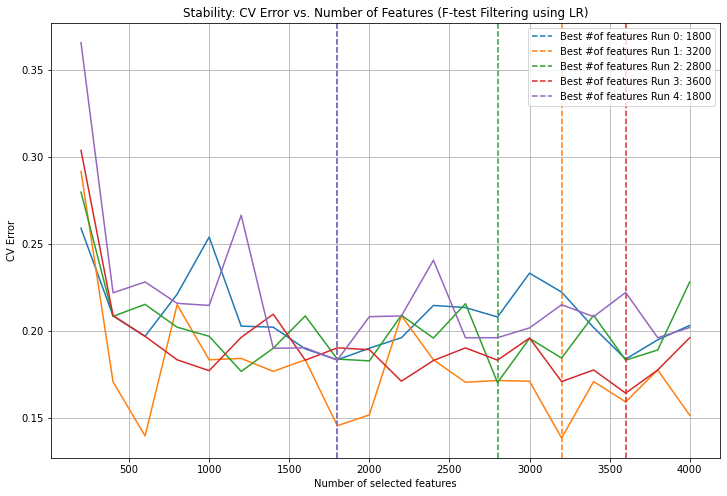

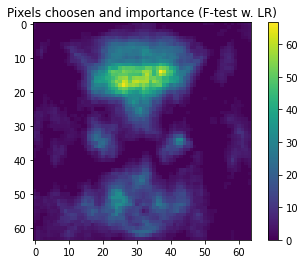

besk k mean: 2640.0 with standard deviation: 731.0266752998826


In [ ]:

classifier = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=10000)

feature_subsets = [k for k in range(100, 4100, 100)]
itterations = 5
all_errors = []  # List to store error curves from all runs

for itteration in range(itterations):
    #print(f"Run {itteration}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    CV_folds = KFold(n_splits=5, shuffle=True)

    feature_subset_errors = []
    for k in feature_subsets:
        selected_index = sorted_by_feature_index[:k]

        CV_errors = []

        for train_idx, test_idx in CV_folds.split(X_train, y_train):
            X_train_cv = X_train[train_idx][:, selected_index]
            y_train_cv = y_train[train_idx]

            X_test_cv = X_train[test_idx][:, selected_index]
            y_test_cv = y_train[test_idx]

            classifier.fit(X_train_cv,y_train_cv)
            yPred = classifier.predict(X_test_cv)
            CV_errors.append(zero_one_loss(y_test_cv, yPred))
        
        feature_subset_errors.append(np.mean(CV_errors))

    all_errors.append(feature_subset_errors)


all_errors = np.array(all_errors) 
best_ks = []

plt.figure(figsize=(12, 8))
for i in range(itterations):
    color = plt.cm.tab10(i % 10)
    best_k_index = np.argmin(all_errors[i])
    best_k = feature_subsets[best_k_index]
    best_ks.append(best_k)

    plt.plot(feature_subsets, all_errors[i],color = color)
    plt.axvline(best_k, linestyle='--', label=f'Best #of features Run {i}: {best_k:.0f}',color = color)

best_k_mean = np.mean(best_ks)
plt.xlabel("Number of selected features")
plt.ylabel("CV Error")
plt.title("Stability: CV Error vs. Number of Features (F-test Filtering using LR)")
plt.grid(True)
plt.legend()
plt.show()

heatmap = np.zeros(4096)
top_k_indices = sorted_by_feature_index[:int(best_k_mean)]
heatmap[top_k_indices] = f_statistic[top_k_indices]
heatmap_reshaped = np.reshape(heatmap,(64,64))

plt.imshow(heatmap_reshaped, cmap='viridis',interpolation="nearest")
plt.title("Pixels choosen and importance (F-test w. LR)")
plt.colorbar()
plt.show()

print(f"besk k mean: {np.mean(best_ks)} with standard deviation: {np.std(best_ks)}")

# Logistic Regression Lasso using CV to choose pentaly param with/without F-test
 λ: This regularization parameter controls the amount of regularization applied. Larger values of lambda increase the penalty, shrinking more of the coefficients towards zero; this subsequently reduces the importance of (or altogether eliminates) some of the features from the model, resulting in automatic feature selection. Conversely, smaller values of lambda reduce the effect of the penalty, retaining more features within the model.
 Use CV to determine the penalty param

In [ ]:
#Try different penalties and perform CV to determine best
C = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04,0.02,0.01]
penalty_param_errors = []

selected_index = sorted_by_feature_index[:int(best_k_mean)]

for penalty_param in C:

    CV_errors = []
    CV_errors_F_test = []
    classifier = LogisticRegression(penalty='l1', solver='liblinear', C=penalty_param, max_iter=10000)
    CV_folds = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, test_idx in CV_folds.split(X_train, y_train):
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]

        X_test_cv = X_train[test_idx]
        y_test_cv = y_train[test_idx]

        classifier.fit(X_train_cv,y_train_cv)

        yPred = classifier.predict(X_test_cv)

        CV_errors.append(zero_one_loss(y_test_cv, yPred))

    
    penalty_param_errors.append(np.mean(CV_errors))

best_c = C[penalty_param_errors.index(np.min(penalty_param_errors))]

"""Fit best c to data and retreive betas"""
best_classifier = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, max_iter=10000)
best_classifier.fit(X_train,y_train)
#best_yPred = best_classifier.predict(X_test)
#best_loss = zero_one_loss(y_test,best_yPred)
betas = best_classifier.coef_
betas = np.reshape(betas, (64, 64))

"""Using Filtering F-test before"""
X_train_F_test = X_train[:, selected_index]
#X_test_F_test = X_test[:, selected_index]
best_classifier_F_test = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, max_iter=10000)
best_classifier_F_test.fit(X_train_F_test,y_train)
#best_yPred_F_test = best_classifier_F_test.predict(X_test_F_test)
#best_loss_F_test = zero_one_loss(y_test,best_yPred_F_test)

betas_F_test = best_classifier_F_test.coef_

betas_F_test_full = np.zeros(4096)
betas_F_test_full[selected_index] = betas_F_test
betas_F_test_full = np.reshape(betas_F_test_full, (64, 64))

# Plot CV errors
lambdas = [1/c for c in C]
plt.figure()
plt.plot(lambdas, penalty_param_errors, marker='o', label='Lasso')
plt.xlabel("Penalty param λ")
plt.ylabel("Mean CV Error")
plt.title("CV Error vs. Penalty param")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(betas), cmap="viridis", interpolation="nearest")
plt.title(f"L1-LR: Pixel Importance (best c={best_c})")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.abs(betas_F_test_full), cmap="viridis", interpolation="nearest")
plt.title(f"F-test + L1-LR: Pixel Importance (best c={best_c})")
plt.colorbar()
plt.show()


#print(f"Best c value:{best_c}\nLoss without F-test filtering: {best_loss} and #of features = {len(betas)} \nLoss with F-test filtering: {best_loss} and #of features = {len(betas_F_test_full)} ")
